<a href="https://colab.research.google.com/github/nikhilScripts/Image-Segmentation/blob/main/U_Net_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Building U-Net from scratch**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)




Output shape: torch.Size([1, 1, 161, 161])


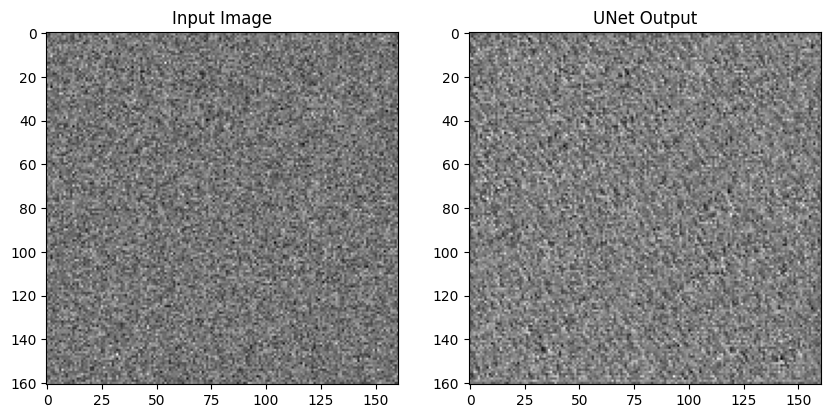

In [15]:
def test_model():
    x = torch.randn((1, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(f"Output shape: {preds.shape}")
    return x, preds

def plot_results(x, preds):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(x[0, 0].detach().numpy(), cmap='gray')
    ax[0].set_title("Input Image")
    ax[1].imshow(preds[0, 0].detach().numpy(), cmap='gray')
    ax[1].set_title("UNet Output")
    plt.show()

if __name__ == "__main__":
    x, preds = test_model()
    plot_results(x, preds)


In [9]:
# Add this import to the top of your script:
!pip install torchviz

  Using cached torchviz-0.0.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached torchviz-0.0.3-py3-none-any.whl (5.7 kB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)


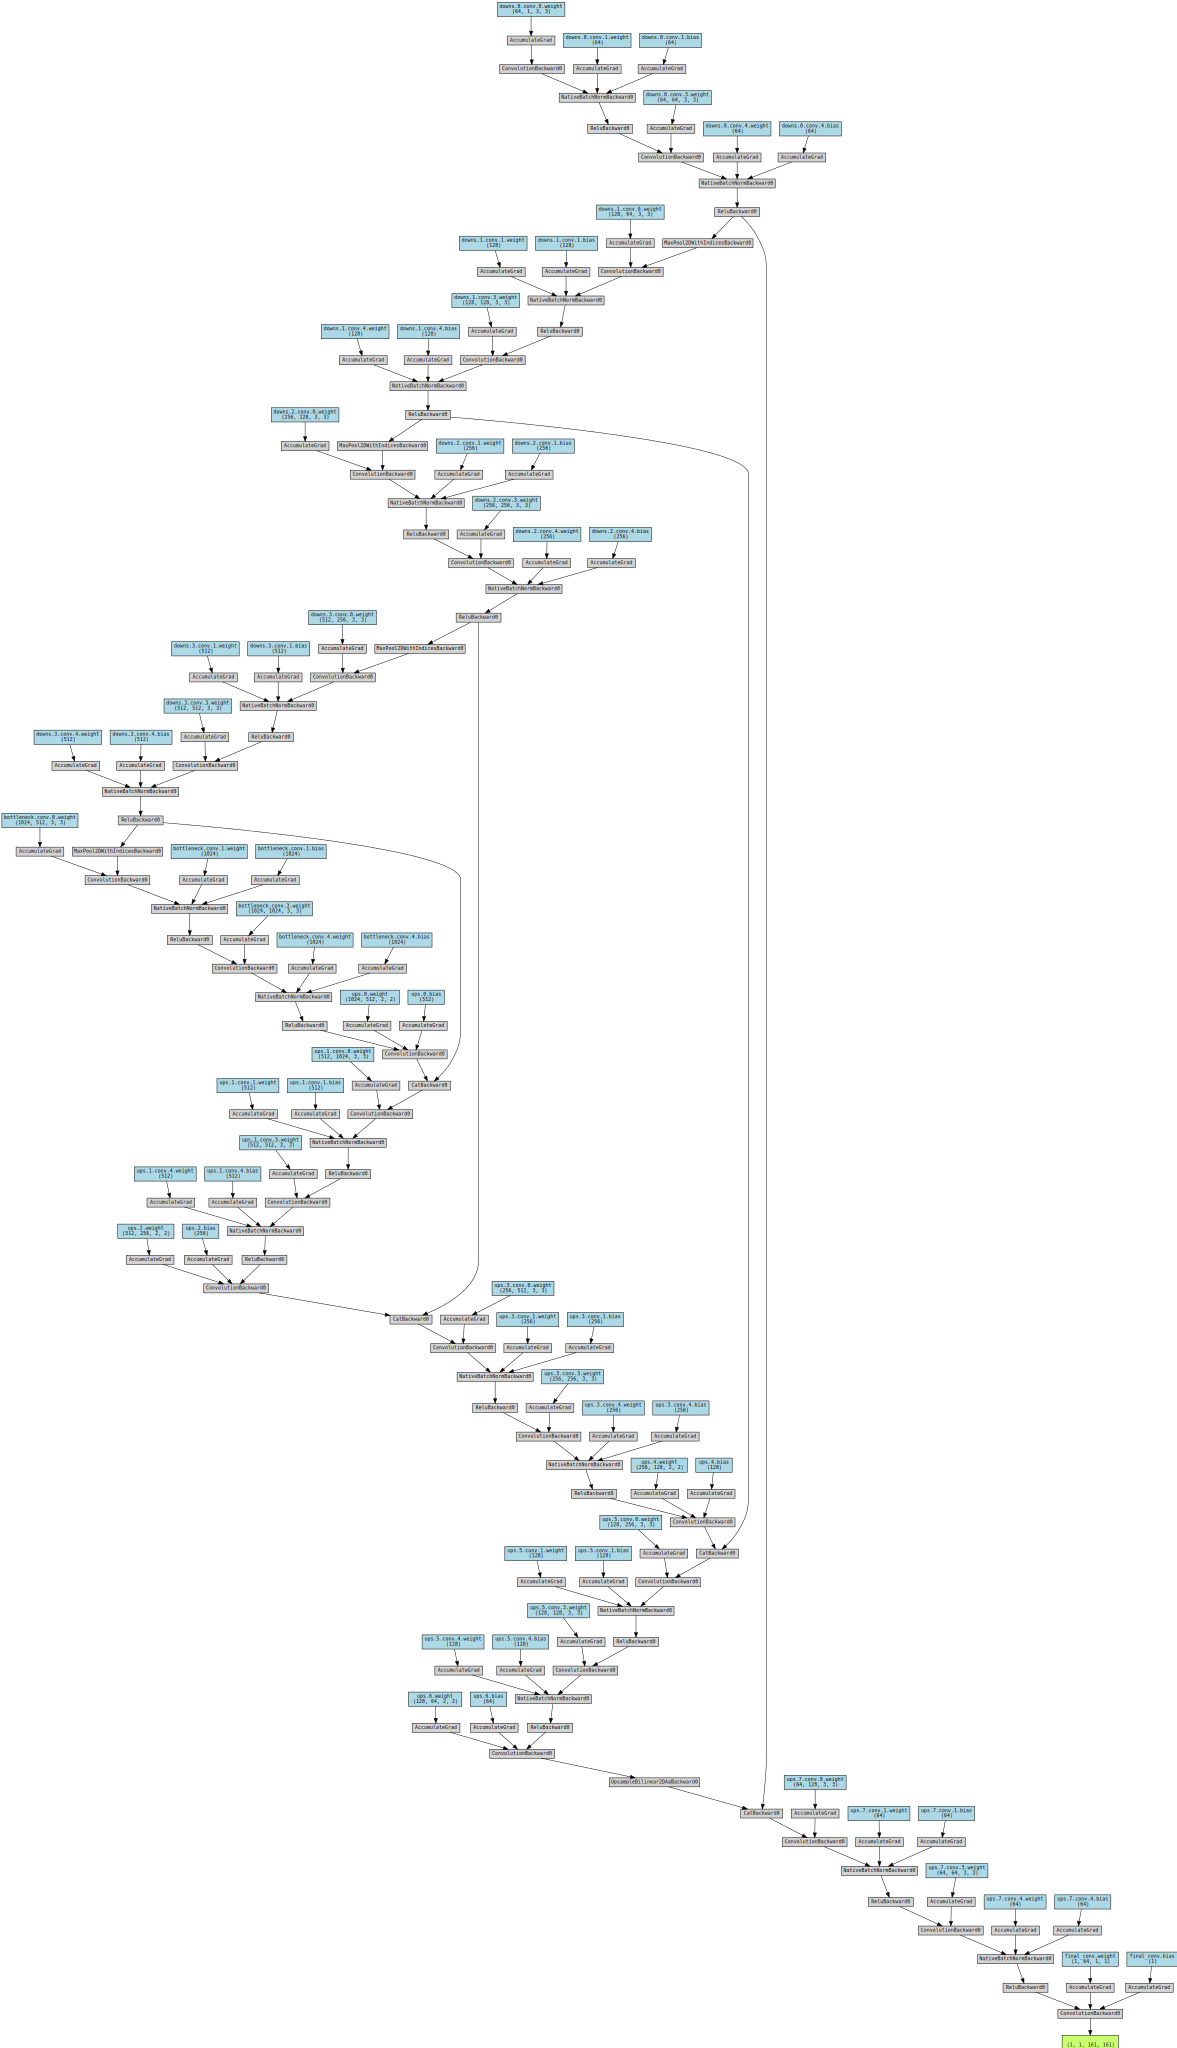

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 161, 161]             576
       BatchNorm2d-2         [-1, 64, 161, 161]             128
              ReLU-3         [-1, 64, 161, 161]               0
            Conv2d-4         [-1, 64, 161, 161]          36,864
       BatchNorm2d-5         [-1, 64, 161, 161]             128
              ReLU-6         [-1, 64, 161, 161]               0
        DoubleConv-7         [-1, 64, 161, 161]               0
         MaxPool2d-8           [-1, 64, 80, 80]               0
            Conv2d-9          [-1, 128, 80, 80]          73,728
      BatchNorm2d-10          [-1, 128, 80, 80]             256
             ReLU-11          [-1, 128, 80, 80]               0
           Conv2d-12          [-1, 128, 80, 80]         147,456
      BatchNorm2d-13          [-1, 128, 80, 80]             256
             ReLU-14          [-1, 128,

In [22]:
import torchviz

def visualize_model():
    model = UNET(in_channels=1)
    x = torch.randn(1, 1, 161, 161)
    dot = torchviz.make_dot(model(x), params=dict(model.named_parameters()))
    return dot

if __name__ == "__main__":

    from IPython.display import display

    display(visualize_model())
    try:
        from torchsummary import summary
        summary(UNET(in_channels=1), (1, 161, 161))
    except ImportError:
        print("Please install torchsummary: !pip install torchsummary")